### **VAR MODEL**

In [ ]:
#imorting libraries
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [ ]:
#imorting data frame
df = pd.read_csv('/content/data_solar.csv')
df

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,25,26,27,28,29,30,31,32,33,34,35,36,37,39,40,41,42,43,45) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Source,Location ID,City,State,Country,Latitude,Longitude,Time Zone,Elevation,Local Time Zone,Clearsky DHI Units,Clearsky DNI Units,Clearsky GHI Units,Dew Point Units,DHI Units,DNI Units,GHI Units,Solar Zenith Angle Units,Temperature Units,Pressure Units,Relative Humidity Units,Precipitable Water Units,Wind Direction Units,Wind Speed,Cloud Type -15,Cloud Type 0,Cloud Type 1,Cloud Type 2,Cloud Type 3,Cloud Type 4,Cloud Type 5,Cloud Type 6,Cloud Type 7,Cloud Type 8,Cloud Type 9,Cloud Type 10,Cloud Type 11,Cloud Type 12,Fill Flag 0,Fill Flag 1,Fill Flag 2,Fill Flag 3,Fill Flag 4,Fill Flag 5,Surface Albedo Units,Version
0,NSRDB,649664,-,-,-,29.53,-98.78,-6,327,-6,w/m2,w/m2,w/m2,c,w/m2,w/m2,w/m2,Degree,c,mbar,%,cm,Degrees,m/s,NaN,Clear,Probably Clear,Fog,Water,Super-Cooled Water,Mixed,Opaque Ice,Cirrus,Overlapping,Overshooting,Unknown,Dust,Smoke,NaN,Missing Image,Low Irradiance,Exceeds Clearsky,Missing CLoud Properties,Rayleigh Violation,NaN,v3.0.1
1,Year,Month,Day,Hour,Minute,DHI,DNI,GHI,Dew Point,Surface Albedo,Wind Speed,Wind Direction,Relative Humidity,Temperature,Pressure,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018,1,1,0,0,0,0,0,-9.4,0.11,5.7,17,58.63,-2.4,996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018,1,1,0,30,0,0,0,-9.4,0.11,5.5,17,59.5,-2.6,996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018,1,1,1,0,0,0,0,-10,0.11,5.4,17,57.79,-2.8,996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17517,2018,12,31,21,30,0,0,0,-7,0.11,5.9,17,65.22,-1.3,995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17518,2018,12,31,22,0,0,0,0,-7.9,0.11,5.9,17,61.94,-1.6,995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17519,2018,12,31,22,30,0,0,0,-7.9,0.11,5.9,17,62.86,-1.8,995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17520,2018,12,31,23,0,0,0,0,-8.8,0.11,5.8,17,60.35,-2.1,995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## **DATA CLEAN UP AND SORTING IN SEASONS**

In [ ]:
#clean up and segregation of data

# droping unnecessary rows and columns
df.drop(df.iloc[:,14:46],inplace= True, axis= 1)
df.columns = df.iloc[1]
df2 = df.drop([0,1])

#defining column for date and time
df2['Date'] = pd.to_datetime(df2[["Year", "Month", "Day", "Hour", "Minute"]])

#spliting the dataframe according to seasons
df_Summer = df2.iloc[ 8208:12720 , : ]

df_Spring = df2.iloc[ 3792:8208 , : ]

df_Autumn = df2.iloc[ 12720:17040 , : ]

df_Winter1 = df2.iloc[ 17040:17521 , : ]
df_Winter2 = df2.iloc[ 2:3792, : ]
df_winter3 = [df_Winter1, df_Winter2]
df_Winter = pd.concat(df_winter3)

#droping "hour", "minute", "day", "month" and "year" columns and setting index to "Date" for all seasons
df_Summer.drop(df_Summer.iloc[:,0:5],inplace= True, axis= 1)
df_Summer_Train = df_Summer.set_index('Date')

df_Winter.drop(df_Winter.iloc[:,0:5],inplace= True, axis= 1)
df_Winter_Train = df_Winter.set_index('Date')

df_Spring.drop(df_Spring.iloc[:,0:5],inplace= True, axis= 1)
df_Spring_Train = df_Spring.set_index('Date')

df_Autumn.drop(df_Autumn.iloc[:,0:5],inplace= True, axis= 1)
df_Autumn_Train = df_Autumn.set_index('Date')

#droping rows with zero value (only for a single season)
Summer = df_Summer_Train[df_Summer_Train.GHI != "0"]

#Initialising summer frame to the MAIN DATA FRAME and removing unwanted parameters
DF=Summer.drop(columns=['Dew Point','Wind Speed','Wind Direction','Surface Albedo'])

#Converting the data type to float
df_1=DF
int_columns=df_1.columns.to_list()
def dtype_converter(a,int_columns):
  for col in int_columns:
    a[col]=a[col].astype(float)
  return a
DF= dtype_converter(df_1,int_columns)
DF

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


1,DHI,DNI,GHI,Relative Humidity,Temperature
Date,,,,,
2018-06-21 05:30:00,2.0,10.0,2.0,98.17,23.6
2018-06-21 06:00:00,26.0,205.0,41.0,96.49,23.9
2018-06-21 06:30:00,46.0,424.0,119.0,93.10,24.5
2018-06-21 07:00:00,60.0,567.0,217.0,88.86,25.1
2018-06-21 07:30:00,69.0,664.0,321.0,83.76,26.1
...,...,...,...,...,...
2018-09-22 16:30:00,163.0,41.0,181.0,69.94,24.9
2018-09-22 17:00:00,77.0,11.0,81.0,71.99,24.2
2018-09-22 17:30:00,7.0,0.0,7.0,71.99,24.2


## **Step 1-Analyse the time series characteristics**

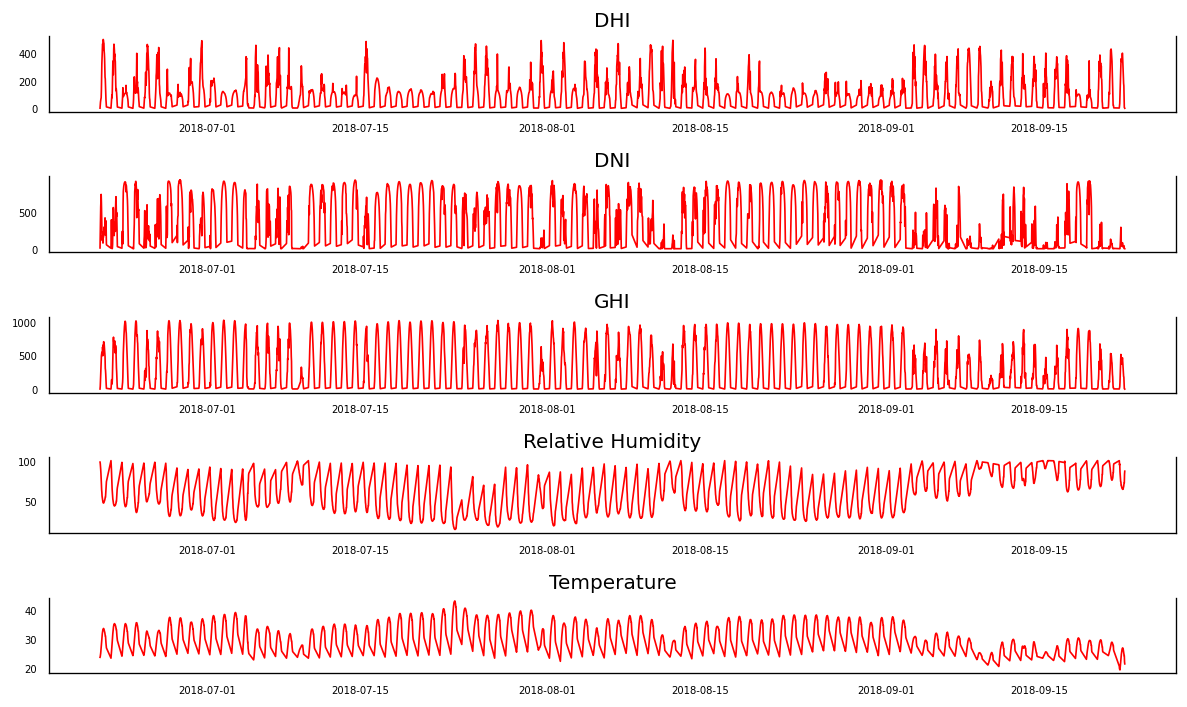

In [ ]:
#Visualize the Time Series
fig, axes = plt.subplots(nrows=5, ncols=1, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = DF[DF.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(DF.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

## **Step 2-Prepare training, test datasets and visualizing for last 2 days**

In [ ]:
#spliting our data frame in to test and train
nobs = 44
DF_train, DF_test = DF[0:-nobs], DF[-nobs:]

#Visualize the Time Series(For Two Days)
fig, axes = plt.subplots(nrows=5, ncols=1, dpi=1000, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = DF_test[DF_test.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(DF_test.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

## **Step 3-Test for causation amongst the time series**

In [ ]:
  #Testing Causation using Granger’s Causality Test
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table
    are the P-Values. P-Values lesser than the significance level (0.05), implies
    the Null Hypothesis that the coefficients of the corresponding past values is
    zero, that is, the X does not cause Y can be rejected.
    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df


grangers_causation_matrix(DF, variables = DF.columns)

,DHI_x,DNI_x,GHI_x,Relative Humidity_x,Temperature_x
DHI_y,1.0,0.0,0.0,0.0,0.0
DNI_y,0.0,1.0,0.0,0.0,0.0
GHI_y,0.0,0.0,1.0,0.0,0.0
Relative Humidity_y,0.0,0.0,0.0,1.0,0.0
Temperature_y,0.0,0.0,0.0,0.0,1.0


## **Step 4-Test for stationarity (Cointegration Test)**

In [ ]:
#Cointegration Test
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df):
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df.astype(float),-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    alpha=0.05
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)   =>   Signif  \n', '--'*40)
    for col, trace, cvt in zip(DF.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(DF)


Name   ::  Test Stat > C(95%)   =>   Signif  
 --------------------------------------------------------------------------------
DHI    ::  1399.71   > 60.0627   =>   True
DNI    ::  543.81    > 40.1749   =>   True
GHI    ::  196.2     > 24.2761   =>   True
Relative Humidity ::  50.91     > 12.3212   =>   True
Temperature ::  0.25      > 4.1296    =>   False


## **Step 5-Transform the series to make it stationary**
we had to diffence the data once to achieve this

In [ ]:
#Check for Stationarity and Make the Time Series Stationary
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")


 # ADF Test on each column
print('ADF TEST')
for name, column in DF_train.iteritems():
    adfuller_test(column.astype(float), name=column.name)
    print('\n')

# 1st difference
DF_train_diff =DF_train.astype(float).diff().dropna()

# ADF Test on each column of 1st Differences Dataframe
print('ADF TEST OH 1st DIFFERENCES')
for name, column in DF_train_diff.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


ADF TEST
    Augmented Dickey-Fuller Test on "DHI" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.8079
 No. Lags Chosen       = 24
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "DNI" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.9866
 No. Lags Chosen       = 27
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.0015. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "GHI" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level

## **Step 6- Find optimal order**

BEST ORDER 34 BEST AIC: 23.920010255850958


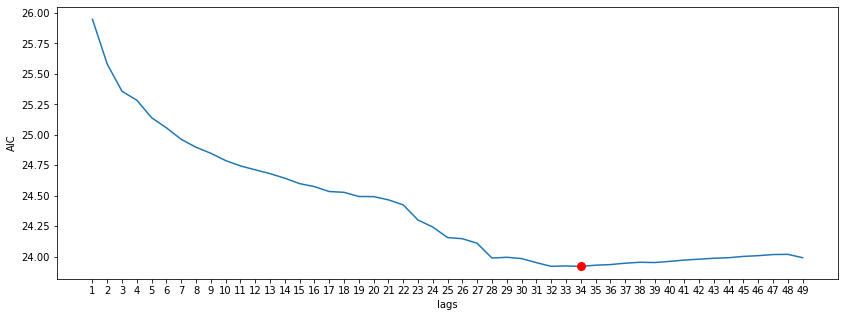

In [ ]:
### FIND BEST VAR ORDER ###

AIC = {}
best_aic, best_order = np.inf, 0

for i in range(1,50):
    model = VAR(endog=DF_train_diff.values)
    model_result = model.fit(maxlags=i)
    AIC[i] = model_result.aic

    if AIC[i] < best_aic:
        best_aic = AIC[i]
        best_order = i

print('BEST ORDER', best_order, 'BEST AIC:', best_aic)


### PLOT AICs ###

plt.figure(figsize=(14,5))
plt.plot(range(len(AIC)), list(AIC.values()))
plt.plot([best_order-1], [best_aic], marker='o', markersize=8, color="red")
plt.xticks(range(len(AIC)), range(1,50
                                  ))
plt.xlabel('lags'); plt.ylabel('AIC')
np.set_printoptions(False)

In [ ]:
#Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic

model_fitted = model.fit(34) ## 34 ORDER ##
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)
def adjust(val, length= 6): return str(val).ljust(length)

for col, val in zip(DF_train.columns, out):
    print(adjust(col), ':', round(val, 2))



DHI    : 2.0
DNI    : 2.0
GHI    : 2.0
Relative Humidity : 2.0
Temperature : 2.0


## **Train the model, Forcasting to the Future**

In [ ]:
# Get the lag order
lag_order = model_fitted.k_ar

# Input data for forecasting
forecast_input = DF_train_diff.values[-lag_order:]
forecast_input

# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=DF_test.index[-nobs:], columns = DF_train.columns + '_1d')
df_forecast

def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

#Results
df_results = invert_transformation(DF_test.astype(float), df_forecast.astype(float), second_diff=False)
df_r = df_results.loc[:, ['DHI_forecast', 'DNI_forecast', 'GHI_forecast', 'Relative Humidity_forecast', 'Temperature_forecast']]
df_r

1,DHI_forecast,DNI_forecast,GHI_forecast,Relative Humidity_forecast,Temperature_forecast
Date,,,,,
2018-09-21 09:30:00,40.728433,33.814777,68.508909,80.862290,22.108650
2018-09-21 10:00:00,69.235883,54.437857,123.210060,81.792729,22.007799
2018-09-21 10:30:00,126.918625,93.509333,185.214779,77.556840,22.506420
2018-09-21 11:00:00,172.343040,74.974657,216.434786,71.568493,23.301698
2018-09-21 11:30:00,181.262761,58.463598,232.027375,67.820986,23.924744
2018-09-21 12:00:00,184.064682,102.844579,297.058197,67.145353,23.858111
2018-09-21 12:30:00,206.146469,90.330720,318.626051,65.534581,24.268433
2018-09-21 13:00:00,217.629696,56.516359,296.671055,63.708347,24.505056
2018-09-21 13:30:00,178.370213,137.528978,328.859656,65.254690,24.393398


## **Comparing actual and forcasted**

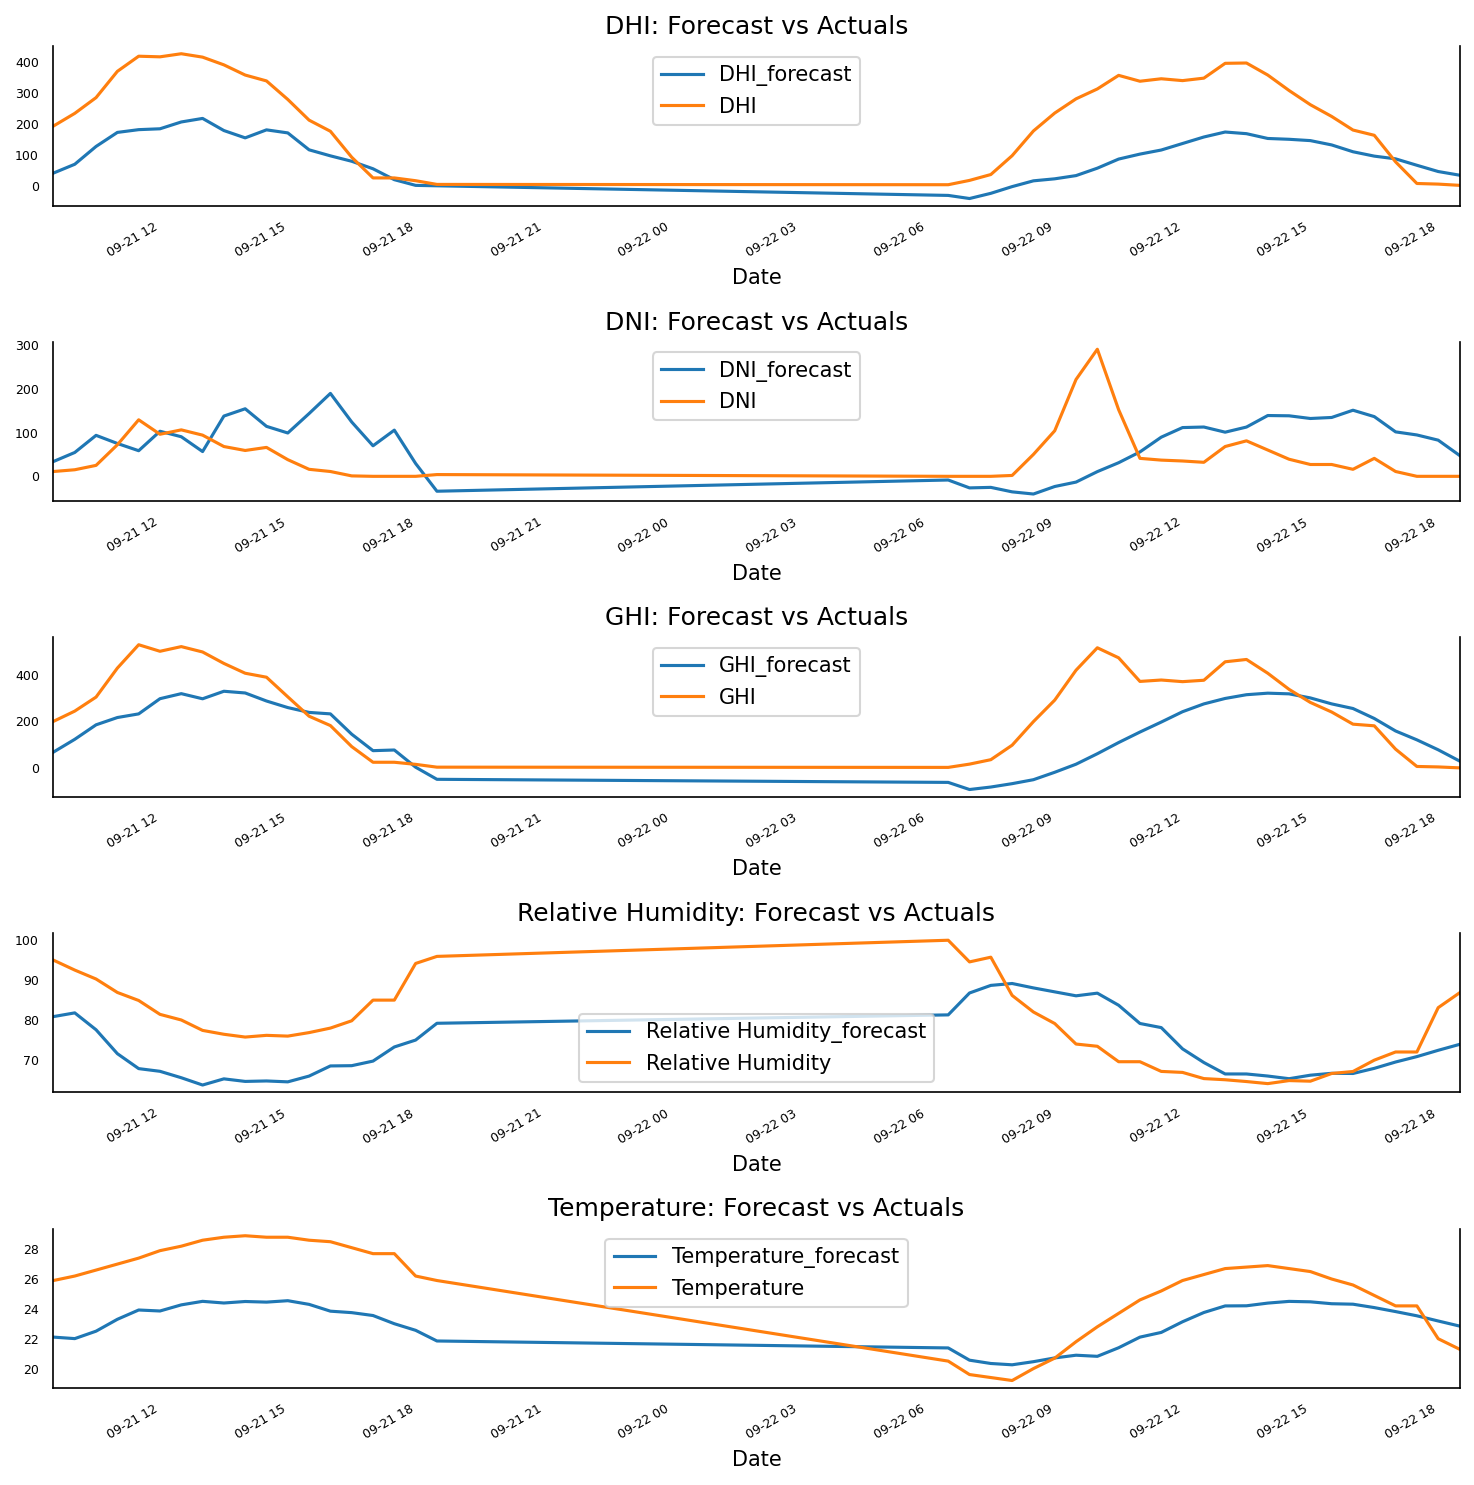

In [ ]:
## PLOTTING PREIDICTED AND ACTUAL VALUES ##
fig, axes = plt.subplots(nrows=5, ncols=1, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(DF_test.columns, axes.flatten())):
    df_r[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    DF_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

## **MAPE Values**

In [ ]:
## Finding MAPE Values ##
def mape(actual, pred):
  actual , pred = np.array(actual) , np.array(pred)
  return np.mean(np.abs((actual-pred)/actual)) *100
result_DHI = mape(DF_test ['DHI'].tolist(),df_r ['DHI_forecast'].tolist())
result_DNI = mape(DF_test ['DNI'].tolist(),df_r ['DNI_forecast'].tolist())
result_GHI = mape(DF_test ['GHI'].tolist(),df_r ['GHI_forecast'].tolist())
result_H = mape(DF_test ['Relative Humidity'].tolist(),df_r ['Relative Humidity_forecast'].tolist())
result_T = mape(DF_test ['Temperature'].tolist(),df_r ['Temperature_forecast'].tolist())
print('MAPE for DHI=',result_DHI)
print('MAPE for DNI=',result_DNI)
print('MAPE for GHI=',result_GHI)
print('MAPE for Humidity=',result_H)
print('MAPE for Temperature=',result_T)

MAPE for DHI= 202.6243314239734
MAPE for DNI= inf
MAPE for GHI= 285.8139841834848
MAPE for Humidity= 11.457170601591166
MAPE for Temperature= 10.130469379655175


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
